# Events Table Stratified

__Description__: 
A Stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data (or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max. potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for statified sampling; maximum return interval limit for the statified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: A *.csv* file containing mean incremental excess rainfall curves and a *.json* file containing the metadata associated with the curves.


#### Import Libraries

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import mean_frequency_curve
%matplotlib inline

In [2]:
## Excess rainfall parameters:
CN  = 81      # Curve number
mu  = 0.2  #Intial abstraction ratio parameter
PMP = 39.9   #39.9 inches, Probable Maximum Precipitation for the selected duration 

Return_Intervals = np.array([ 2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000]) #Return Intervals evaluated
RI_upper_bound = 3700 #Upper Limit of recurrence interval evaluation, Suggest not changing this value
Aerial_Reduction = 0.9216 #Aerial Reduction Factor

duration = 24   # Event duration in hour #Must be a duration in the input Precip_Table File

#Integration parameters
n_partition = 30 #Define number of partitions of max. potential retention distribution.
                 #This controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'Amite_WA2'  # Project area name #DesPlaines, Amite_WA2
Pluvial_Model = 'P01'  # Pluvial model name
BCN =         '080702020804'   # 080702020804 Domain/boundary condition name #071200040403

#NOAA Data
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)
#Mean Precip Curve Data
precip_mean_curve_table = 'MeanCurve_{0}.csv'.format(Project_Area, Pluvial_Model, BCN) 

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_plots = True
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [3]:
inputs_dir = pl.Path(inputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
## Excess rainfall parameters:
lower_limit, upper_limit = 1, 3000 

## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'

### NOAA Atlas 14 Precipitation Values

,Median,Lower (90%),Upper (90%)
Tr,,,
1,4.278450,3.550713,5.134769
2,5.000066,4.145173,6.005280
5,6.280423,5.189506,7.559968
10,7.437209,6.111701,8.985660
25,9.169730,7.361175,11.543475
50,10.616287,8.306353,13.478353
100,12.159239,9.199587,15.756654
200,13.823333,10.044771,18.320277
500,16.175710,11.313314,21.929392


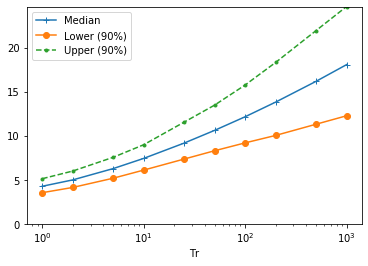

In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)

raw_precip.rename(columns = {'Expected Value':'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0,raw_precip['Upper (90%)'].max() ))

raw_precip

### Fit GEV to Rainfal Data (Find GEV parameters)

In [6]:
#reduce precip by aerial reduction factor
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns] * Aerial_Reduction

#Find GEV parameter values
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)

dfs = [df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U]
df_GEV_parameters = pd.concat(dfs, axis=1)
df_GEV_parameters

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.12079625541050779
            Iterations: 24
            Function evaluations: 128
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.13845677596352426
            Iterations: 17
            Function evaluations: 87
            Gradient evaluations: 17


../../core\hydromet_stratified.py:89: RuntimeWarning:

divide by zero encountered in double_scalars



Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.1560606093110142
            Iterations: 20
            Function evaluations: 111
            Gradient evaluations: 19


,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,4.411776,3.655813,5.289589
sigma,0.928430,0.856085,1.095949
xi,-0.178520,-0.076008,-0.232102


### Plot Fitted GEV Distribution and NOAA Data

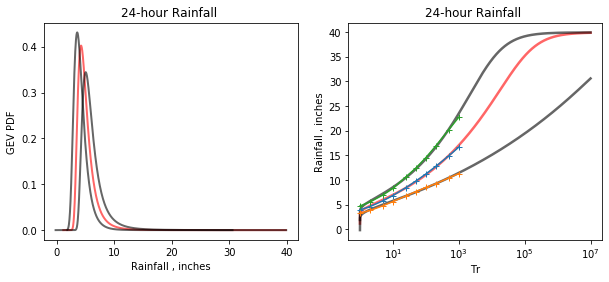

In [7]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP,  'Rainfall')

### Data for Calculating the Mean Curve

In [8]:
#Additional Return Intervals evaluated for the mean curve
return_intervals_MC =  np.array([ 1.01, 1.05, 1.11, 1.25, 20,\
                                 2000, 5000, 10000, 20000,\
                                 50000., 100000., 200000., 1/2E-06,\
                                1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07 ]) 

return_interval_data = return_interval_data(raw_precip_reduced, return_intervals_MC, df_GEV_parameters, PMP)
return_interval_data

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,3.943019,3.272337,4.732203,0.113339,0.110908,0.113339,1.371947
1.01,3.169220,2.419799,3.878684,0.164013,0.122803,0.164013,1.153486
1.05,3.474354,2.741909,4.214296,0.143923,0.117370,0.143923,1.245409
1.11,3.689184,2.960819,4.454978,0.133702,0.114661,0.133702,1.305405
1.25,3.988193,3.255694,4.795749,0.123363,0.112092,0.123363,1.383338
2.00,4.608061,3.820192,5.534466,0.113986,0.111360,0.113986,1.527807
5.00,5.788038,4.782649,6.967266,0.115987,0.112723,0.115987,1.755793
10.00,6.854132,5.632544,8.281185,0.119326,0.114975,0.119326,1.924852
20.00,8.048528,6.508451,9.971406,0.129111,0.130232,0.130232,2.085489
25.00,8.450823,6.784059,10.638467,0.133549,0.139947,0.139947,2.134264


### Input for Calculating the Mean Curve

In [9]:
#Confidence Limits Evaluated
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, .99, 0.995, 0.999])
#Inputs for the mean curve. Table is exported as a csv
mean_curve_input_table(CL, return_interval_data, PMP, outputs_dir, Project_Area, Pluvial_Model, BCN, inputs_dir)

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,38.026092,38.452545,38.638075,39.073262,39.262603,39.453109,39.565093,39.644791,39.706751,39.757466,39.800410,39.837657,39.870549,39.885659,39.897189,39.898598,39.899720
2.000000e-07,37.094509,37.725234,38.001053,38.651407,38.935845,39.222943,39.392131,39.512733,39.606603,39.683510,39.748682,39.805247,39.855225,39.878194,39.895726,39.897868,39.899575
5.000000e-07,35.613929,36.558331,36.974806,37.965228,38.402123,38.845410,39.107726,39.295206,39.441413,39.561386,39.663183,39.751632,39.829859,39.865833,39.893302,39.896659,39.899333
1.000000e-06,33.640233,34.977460,35.574641,37.013332,37.656315,38.313967,38.705641,38.986721,39.206587,39.387438,39.541198,39.675029,39.793569,39.848139,39.889831,39.894928,39.898988
2.000000e-06,29.165802,31.257370,32.224405,34.642191,35.764737,36.940935,37.655295,38.174467,38.584429,38.924210,39.214935,39.469363,39.695810,39.800400,39.880455,39.890251,39.898054
5.000000e-06,21.732245,24.534158,25.924354,29.703866,31.626879,33.774337,35.151852,36.190805,37.035113,37.751662,38.377330,38.934739,39.438826,39.674251,39.855581,39.877835,39.895574
1.000000e-05,16.800748,19.582721,21.034693,25.266776,27.609146,30.410002,32.327328,33.845552,35.130428,36.260374,37.279244,38.214259,39.083584,39.497757,39.820452,39.860281,39.892065
2.000000e-05,13.387088,15.863673,17.197454,21.281609,23.696962,26.774023,29.029188,30.921688,32.611845,34.177378,35.663301,37.099042,38.505765,39.203529,39.760727,39.830363,39.886072
5.000000e-05,10.819148,12.848905,13.958337,17.452597,19.611662,22.505116,24.764597,26.784592,28.715063,30.643287,32.638973,34.774975,37.146079,38.462425,39.601148,39.749805,39.869836


### Calculate the Mean Precipitation Curve

Specified inputs_path is to a csv, loaded table.

Values increase with decreasing annual exceedance probability for all confidence limits as expected



,P_Mean_in,P_Median_in
AEP,,
0.9,3.530070,3.692513
0.5,4.719528,4.608061


C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs - already exists



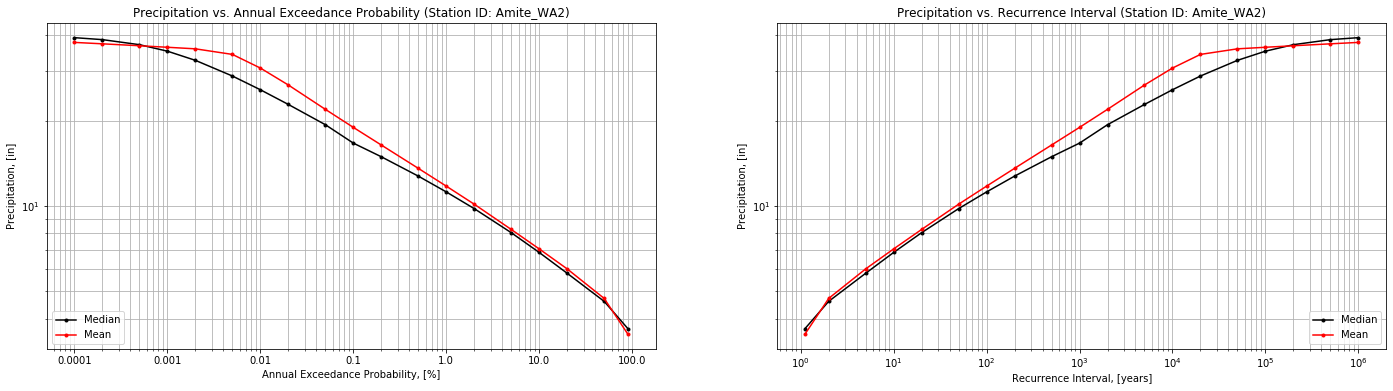

In [10]:
inputs_path= os.path.join(root_dir,'Inputs','Mean_Curve_Input_{0}_{1}_{2}.csv'.format(Project_Area, Pluvial_Model, BCN))
df = mean_frequency_curve.main(Project_Area, inputs_path, outputs_dir, data_type = 'P', round_decimals = 6)

## Hydrology 2

,P_Mean_in,P_Median_in
Tr,,
1.111111,3.530070,3.692513
2.000000,4.719528,4.608061
5.000000,5.997485,5.788038
10.000000,7.053969,6.854132
20.000000,8.262431,8.048528
50.000000,10.141250,9.783970
100.000000,11.745087,11.205955
200.000000,13.570298,12.739583
500.000000,16.398151,14.907522


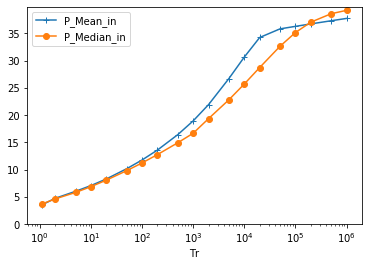

In [11]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)

mean_curve_precip['Tr'] = 1/mean_curve_precip.index.to_numpy()
mean_curve_precip = mean_curve_precip.set_index('Tr')

mean_curve_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, PMP))

mean_curve_precip

### Fit GEV to Mean Precipication Curve (Find GEV parameters)

In [12]:
#Find GEV parameters for the median curve
fit_values_mean_curve_precip = mean_curve_precip[1:20000] #Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.to_numpy().transpose()[0]

df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.09950380677911225
            Iterations: 15
            Function evaluations: 79
            Gradient evaluations: 15


,GEV Median,GEV Lower (90%),GEV Upper (90%),GEV P_Mean_in
mu,4.411776,3.655813,5.289589,4.267400
sigma,0.928430,0.856085,1.095949,0.918184
xi,-0.178520,-0.076008,-0.232102,-0.227794


### Plot Fitted GEV Distribution and Mean Precipitation Curve

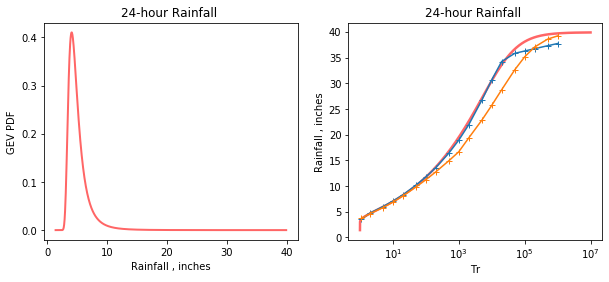

In [13]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP,  'Rainfall')

### Hydrology 2 Events

In [14]:
#Here add in script that processes the mean curve data points that are equivalent in RI to the original NOAA data points

#Return Intervals where precipitation already is calculated for the mean precip. curve.
RI_data = np.array([ 2, 5, 10, 50, 100, 200, 500, 1000, 2000])

df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', RI_data , CN, mu)
df_weights_rainfall

Bin Ceiling = 3700.0, Bin Average = 3000, Bin Floor = 2575.4879760050317
Bin Ceiling = 2575.4879760050317, Bin Average = 2000, Bin Floor = 1607.5988971021118
Bin Ceiling = 1607.5988971021118, Bin Average = 1000, Bin Floor = 692.1388722609275
Bin Ceiling = 692.1388722609275, Bin Average = 500, Bin Floor = 380.9365705783591
Bin Ceiling = 380.9365705783591, Bin Average = 200, Bin Floor = 125.68832509964531
Bin Ceiling = 125.68832509964531, Bin Average = 100, Bin Floor = 81.76859685918674
Bin Ceiling = 81.76859685918674, Bin Average = 50, Bin Floor = 34.18415007902683
Bin Ceiling = 34.18415007902683, Bin Average = 25, Bin Floor = 19.20630120145199
Bin Ceiling = 19.20630120145199, Bin Average = 10, Bin Floor = 6.271596670326927
Bin Ceiling = 6.271596670326927, Bin Average = 5, Bin Floor = 4.099749054539204
Bin Ceiling = 4.099749054539204, Bin Average = 2, Bin Floor = 1.2571141693147703


,Bin Floor,Bin Celing,Event Weight,P_Mean_in,Runoff
2.0,1.257114,4.099749,0.551555,4.719528,2.738878
5.0,4.099749,6.271597,0.084468,5.997485,3.881450
10.0,6.271597,19.206301,0.107383,7.053969,4.855268
25.0,19.206301,34.184150,0.022813,8.587114,6.298139
50.0,34.184150,81.768597,0.017024,10.141250,7.784274
100.0,81.768597,125.688325,0.004273,11.745087,9.334204
200.0,125.688325,380.936571,0.005331,13.570298,11.111686
500.0,380.936571,692.138872,0.001180,16.398151,13.884420
1000.0,692.138872,1607.598897,0.000823,18.923625,16.373337
2000.0,1607.598897,2575.487976,0.000234,21.910376,19.326874


# Hydrology 3
### Retreive Max. Potential Retention Variability and Distribution Parameters

In [15]:
#NRCS value of wet and dry soil moiture conditions
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

#Table of wet, dry, and average (or median) soil moisture conditions
df_CN = prep_cn_table(CN, arc_data)  

#Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)

#Distribution parameter values
S_limit = 1000/fitted_cn.iloc[0]['CN Lower Limit']-10
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

#Define Probability for each partition of the max. potential retention distribution.
Delta_P=1/n_partition

#Find the average value over each partition, which is the basis for the runoff distribution
partition_avg = partition_S_avgs(n_partition, alpha, beta, S_limit)
print(partition_avg )

fitted_cn['mu']= mu
fitted_cn

[0.23376944 0.52727771 0.76140187 0.97232688 1.16985429 1.35865859
 1.54147283 1.72010061 1.89583845 2.06968314 2.24244615 2.41482256
 2.58743654 2.76087373 2.93570679 3.11251785 3.29192032 3.47458285
 3.66125786 3.8528184  4.05030875 4.2550179  4.46859172 4.69321457
 4.93192328 5.18919747 5.47220288 5.79388777 6.18325529 6.76378274]


,AMC I (Dry),AMC II,AMC III (Wet),alpha,beta,CN Lower Limit,Fitted AMC I (Dry),Fitted AMC II,Fitted AMC III (Wet),mu
1,64,81,92,1.452024,1.981606,57.339798,63.999873,80.999205,91.999302,0.2


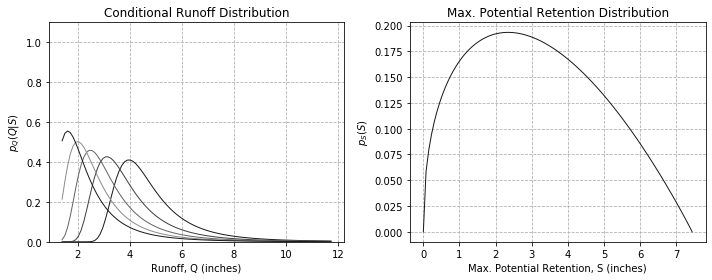

In [16]:
plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)

## Runoff as a function of the return period

In [17]:
#error between the integral approach (based on summation integration) and the actual value
error_PQ = 1- CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P, 0)

#Print Results
print('\n'
      'Probability of zero runoff = %s \n' 
      'Error in calculation of Probabilibity of zero runoff = %s \n'
      'Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = %s'
      %(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP,error_PQ)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP,error_PQ)[1], error_PQ ))

#Time the integration
#  %timeit CDF_Q( 3 , 0.2, alpha, beta, S_limit, GEV_parameters_E)


Probability of zero runoff = 8.979370802954742e-80 
Error in calculation of Probabilibity of zero runoff = 1.7561150321057457e-79 
Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = -1.2926098949872511e-05


### Determine Runoff
Values and Weights
- Runoff weights calculated starting from a given bin ceiling.

In [18]:
df_runoff, df_GEV_parameters_R = runoff_GEV(mu, GEV_parameters_E, PMP, \
           alpha, beta, S_limit, partition_avg, Delta_P, \
           error_PQ)
GEV_parameters_R = df_GEV_parameters_R.to_numpy().transpose()[0]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03679064979936162
            Iterations: 17
            Function evaluations: 89
            Gradient evaluations: 17


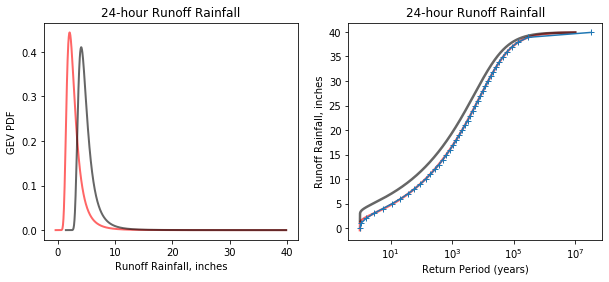

In [19]:
plot_GEV_precip_curves(df_runoff,pd.concat([df_GEV_parameters_R, df_GEV_parameters_E], axis=1), PMP, 'Runoff', 'Rainfall')

In [20]:
df_weights_runoff= runoff_weights(Return_Intervals, RI_upper_bound, mu, GEV_parameters_R,  GEV_parameters_E, PMP, partition_avg, Delta_P, error_PQ)
df_weights_runoff

Bin Ceiling = 3700.0, Bin Average = 3000, Bin Floor = 2492.068699348837
Bin Ceiling = 2492.068699348837, Bin Average = 2000, Bin Floor = 1647.3962842182543
Bin Ceiling = 1647.3962842182543, Bin Average = 1000, Bin Floor = 681.4590816591754
Bin Ceiling = 681.4590816591754, Bin Average = 500, Bin Floor = 384.98826853538316
Bin Ceiling = 384.98826853538316, Bin Average = 200, Bin Floor = 124.92235903398667
Bin Ceiling = 124.92235903398667, Bin Average = 100, Bin Floor = 82.14988343076118
Bin Ceiling = 82.14988343076118, Bin Average = 50, Bin Floor = 34.07793381599771
Bin Ceiling = 34.07793381599771, Bin Average = 25, Bin Floor = 19.245871917170575
Bin Ceiling = 19.245871917170575, Bin Average = 10, Bin Floor = 6.261186370691951
Bin Ceiling = 6.261186370691951, Bin Average = 5, Bin Floor = 4.104648791460444
Bin Ceiling = 4.104648791460444, Bin Average = 2, Bin Floor = 1.2560286451103346


,Bin Floor,Bin Celing,Event Weight,Runoff
2,1.256029,4.104649,0.552534,2.556324
5,4.104649,6.261186,0.083912,3.758035
10,6.261186,19.245872,0.107755,4.747518
25,19.245872,34.077934,0.022615,6.272427
50,34.077934,82.149883,0.017172,7.641864
100,82.149883,124.922359,0.004168,9.240526
200,124.922359,384.988269,0.005407,11.109598
500,384.988269,681.459082,0.001130,14.068163
1000,681.459082,1647.396284,0.000860,16.725669
2000,1647.396284,2492.068699,0.000206,19.767975


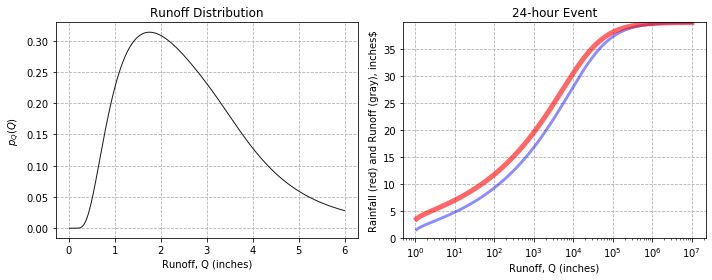

In [21]:
plot_runoff_distributions_final(GEV_parameters_E, GEV_parameters_R, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)

### Plot runoff distribution

### Plot maximum potential distribution conditional on runoff

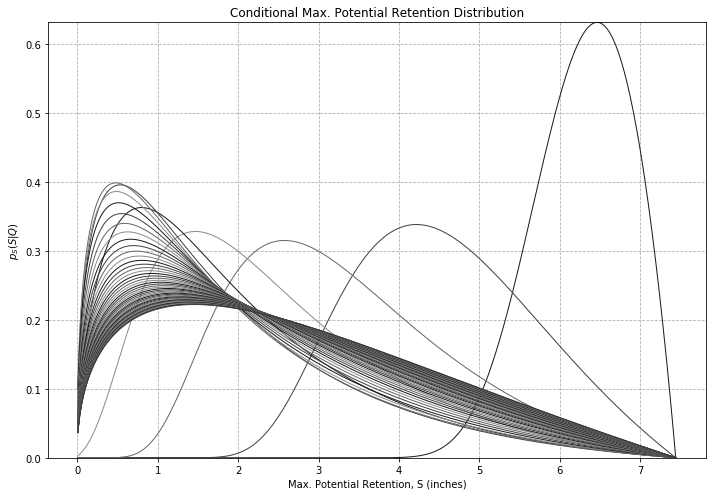

In [22]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)

### Calculate Runoff and Corresponding Max. Potential Retention and Rainfall

In [23]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR1

Calculating Median S for Runoff = 2.5563235204139603
Calculating Median S for Runoff = 3.7580350840543217
Calculating Median S for Runoff = 4.7475182699336
Calculating Median S for Runoff = 6.272426791886289
Calculating Median S for Runoff = 7.64186423238856
Calculating Median S for Runoff = 9.240526213097658
Calculating Median S for Runoff = 11.109598047774
Calculating Median S for Runoff = 14.068162751771965
Calculating Median S for Runoff = 16.72566923996182
Calculating Median S for Runoff = 19.7679747276589
Calculating Median S for Runoff = 21.718028103880023
Calculating Median S for Runoff = 27.52758531818746


,Bin Floor,Bin Celing,Event Weight,Runoff,Avg. S,Rainfall,Median S,Rainfall
2,1.256029,4.104649,0.552534,2.556324,2.775829,4.787920,2.535006,4.633670
5,4.104649,6.261186,0.083912,3.758035,1.945342,5.560709,1.605848,5.293008
10,6.261186,19.245872,0.107755,4.747518,1.824927,6.520095,1.445041,6.197607
25,19.245872,34.077934,0.022615,6.272427,1.891138,8.172537,1.500000,7.823066
50,34.077934,82.149883,0.017172,7.641864,1.987949,9.676650,1.610794,9.330479
100,82.149883,124.922359,0.004168,9.240526,2.092448,11.417009,1.731000,11.077288
200,124.922359,384.988269,0.005407,11.109598,2.195110,13.426356,1.849816,13.094595
500,384.988269,681.459082,0.001130,14.068163,2.321978,16.561824,1.998840,16.242840
1000,681.459082,1647.396284,0.000860,16.725669,2.409356,19.343996,2.102723,19.035523
2000,1647.396284,2492.068699,0.000206,19.767975,2.488375,22.501206,2.200931,22.206983


## Hydrology 3 Events
- For each runoff value, two events are considered, a high max. potential retention, and a low max. potential retention

In [24]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha,beta, S_limit, error_PQ)
df_runoff_SR2

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall,Event Weight,Runoff,Avg. S (Upper 50%),Rainfall
2,0.276267,2.556324,1.690066,4.056268,0.276267,2.556324,3.861592,5.442408
5,0.041956,3.758035,0.851645,4.643806,0.041956,3.758035,3.039038,6.353545
10,0.053877,4.747518,0.724943,5.531456,0.053877,4.747518,2.924912,7.376977
25,0.011307,6.272427,0.744461,7.093703,0.011307,6.272427,3.037815,9.118747
50,0.008586,7.641864,0.805644,8.537952,0.008586,7.641864,3.170254,10.686048
100,0.002084,9.240526,0.873464,10.218801,0.002084,9.240526,3.311432,12.489921
200,0.002704,11.109598,0.941532,12.170845,0.002704,11.109598,3.448688,14.561347
500,0.000565,14.068163,1.028569,15.236568,0.000565,14.068163,3.615387,17.774152
1000,0.000430,16.725669,1.090271,17.970911,0.000430,16.725669,3.728440,20.610595
2000,0.000103,19.767975,1.150556,21.088495,0.000103,19.767975,3.826193,23.814684


---